In [1]:
## Uncomment the following line and run it.
# pip install pandas numpy matplotlib uproot==5.3.10 scikit-learn==1.3.2 tensorflow==2.13.1

## Download the dataset for the following link: 
!https://opendata.cern.ch/record/12100



In [2]:
import numpy as np  # for computation of arrays in python
import pandas as pd  ## used for the processing of the dataset.
import uproot ## handling the root file in python
import matplotlib.pyplot as plt # for visualization 
from sklearn.model_selection import train_test_split  #for random splitting of the dataset for training and testing.
from sklearn.datasets import make_classification # for making the confusion-matrix
from keras.models import Sequential # NLP architecture
from keras.layers import Dense ## DNN
import tensorflow as tf  ## machine learning package
from tensorflow import keras 
from tensorflow.keras import layers

2024-11-02 16:02:46.386327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 16:02:46.855070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-02 16:02:46.856227: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-02 16:02:47.895273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Loading the data from the ROOT file.

We are extracting only the relevant tree from the root file for analysis. 

In [3]:
# pathtoyourrootfile = 'JetNtuple_RunIISummer16_13TeV_MC_103.root' ## add the path of your root file in this.
filelist = [pathtoyourrootfile]
df = pd.DataFrame()

for fl in filelist:
    file = uproot.open(fl)
    thisdf = file["AK4jets/jetTree;14"].arrays(library="pd")
    df = pd.concat([df,thisdf])

In [4]:
df.head()

,jetPt,jetEta,jetPhi,jetMass,jetGirth,jetArea,jetRawPt,jetRawMass,jetLooseID,jetTightID,...,lumi,pthat,eventWeight,rhoAll,rhoCentral,rhoCentralNeutral,rhoCentralChargedPileUp,PV_npvsGood,Pileup_nPU,Pileup_nTrueInt
0,57.387169,-2.224824,-0.665543,11.292787,0.140085,0.498666,49.867775,9.813102,1,1,...,20313,58.465591,0.002180,16.872475,18.693438,5.196937,9.250823,14,17,21.612978
1,34.731983,-1.488804,2.260486,7.156875,0.131862,0.498666,32.354492,6.666969,1,1,...,20313,58.465591,0.002180,16.872475,18.693438,5.196937,9.250823,14,17,21.612978
2,334.307159,-1.443054,0.275756,53.162064,0.117701,0.498666,292.773041,46.557243,1,1,...,20313,302.254395,0.000001,6.047331,8.174967,1.811257,2.411491,6,13,15.243649
3,215.078369,-1.392444,-3.102371,21.610882,0.047651,0.518612,188.413971,18.931667,1,1,...,20313,302.254395,0.000001,6.047331,8.174967,1.811257,2.411491,6,13,15.243649
4,53.059177,-0.567916,-2.626153,7.390332,0.102996,0.498666,50.538086,7.039183,1,1,...,20313,302.254395,0.000001,6.047331,8.174967,1.811257,2.411491,6,13,15.243649


In [5]:
df = df.fillna(value=0)

### Jet Variables in Particle Physics

Jet reconstruction involves analyzing jets at different levels of detail:

1. **High-Level (Reconstructed Level)**:
   - **Jet \( p_T \)**: Transverse momentum of the jet.
   - **Jet Energy**: Total energy of the jet.
   - **Eta (\( $\eta$ \)) & Phi (\( $\phi$ \))**: Direction of the jet.
   - **Jet Mass**: Invariant mass of the jet.
   - **Jet Constituents**: Number of particles forming the jet.
   - **B-Tagging Score**: Likelihood of originating from a b-quark.

2. **Particle-Level**:
   - **Particle \( p_T \)**: Transverse momentum of particles within the jet.
   - **Particle Mass**: Mass of individual particles.
   - **Particle Multiplicity**: Number of particles contributing to the jet.
   - **Jet Flavour**: Initiating parton (quark/gluon) identity.

3. **Generator-Level**:
   - **Generator Jet \( p_T \)**: Simulated transverse momentum.
   - **Parton ID**: The identity of the parton initiating the jet.
   - **Jet Matching**: Correspondence between reconstructed and simulated jets.

4. **Event-Level**:
   - **Event Energy (\( \sqrt{s} \))**: Total collision energy.
   - **Pileup**: Number of simultaneous interactions.
   - **Vertex Position**: Position of the primary interaction.

These variables allow for detailed analysis and comparison between observed and simulated data in jet studies.


In [6]:
for i in range(5):
    print('Number of generator level particle in Jet',i+1,'is',len(df['genJetPF_pT'][i]) ) 

Number of generator level particle in Jet 1 is 29
Number of generator level particle in Jet 2 is 19
Number of generator level particle in Jet 3 is 34
Number of generator level particle in Jet 4 is 23
Number of generator level particle in Jet 5 is 8


### Doing MVA analysis in final jet properties:

In [36]:
x = df[['QG_ptD','QG_axis2','QG_mult']]

In [37]:
light_quark , other = df['isPhysUDS'] , df['isPhysOther']
gluon = df['isPhysG']

In [38]:
x1 = x
y = np.array(light_quark)

In [39]:
y1 = y.reshape(-1)
x1 = np.array(x1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42)

#### Neural Network workflow:

In [89]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') ])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.2,)

Epoch 1/15
1431/1431 [==============================] - 3s 2ms/step - loss: 0.4615 - accuracy: 0.8148 - val_loss: 0.4391 - val_accuracy: 0.7920
Epoch 2/15
1431/1431 [==============================] - 2s 2ms/step - loss: 0.3823 - accuracy: 0.8312 - val_loss: 0.3709 - val_accuracy: 0.8366
Epoch 3/15
1431/1431 [==============================] - 2s 1ms/step - loss: 0.3774 - accuracy: 0.8336 - val_loss: 0.3860 - val_accuracy: 0.8276
Epoch 4/15
1431/1431 [==============================] - 2s 1ms/step - loss: 0.3769 - accuracy: 0.8340 - val_loss: 0.4051 - val_accuracy: 0.8227
Epoch 5/15
1431/1431 [==============================] - 2s 2ms/step - loss: 0.3743 - accuracy: 0.8357 - val_loss: 0.3707 - val_accuracy: 0.8339
Epoch 6/15
1431/1431 [==============================] - 2s 1ms/step - loss: 0.3722 - accuracy: 0.8365 - val_loss: 0.3759 - val_accuracy: 0.8350
Epoch 7/15
1431/1431 [==============================] - 2s 2ms/step - loss: 0.3708 - accuracy: 0.8374 - val_loss: 0.3678 - val_accuracy:

In [90]:
ypred = model.predict(X_test)
y_pred = []
for i in range(ypred.shape[0]):
    if ypred[i][0] < 0.5 :
        y_pred.append(0)
    if ypred[i][0] > 0.5 :
        y_pred.append(1)
y_pred = np.array(y_pred)

894/894 [==============================] - 1s 1ms/step


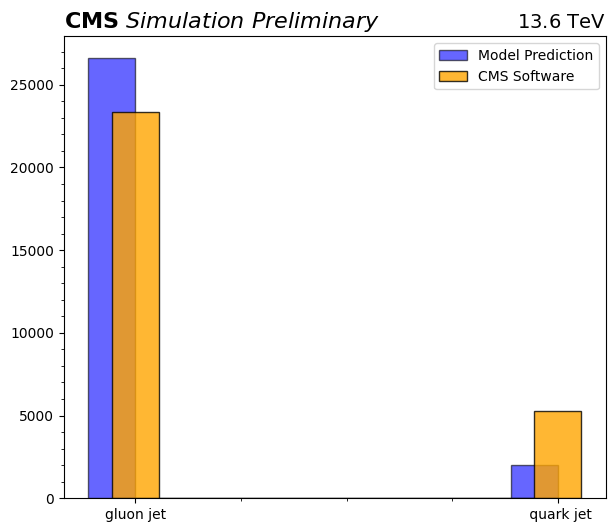

In [91]:
# Create the plot
plt.figure(figsize=(7,6))

# Plot two histograms with transparency
plt.hist(y_pred, bins=10,color='blue', alpha=0.6, label='Model Prediction', edgecolor='black')
plt.hist(y_test + 0.05, bins=10,color='orange', alpha=0.8, label='CMS Software', edgecolor='black')


plt.legend()

# Customize tick marks
# plt.tick_params(axis='both', which='major', length=8, width=1.5, direction='in', top=True, right=True)
# plt.tick_params(axis='both', which='minor', length=4, width=1, direction='in', top=True, right=True)
label = ['gluon jet' , ' quark jet']
plt.xticks(ticks=[0.1,1.0], labels=label)

plt.minorticks_on()
plt.title(r'$\mathbf{CMS}$ $\mathit{Simulation~Preliminary}$', loc='left', fontsize=16)
plt.title(r'$13.6~\mathrm{TeV}$', loc='right', fontsize=14)
plt.savefig("Comparision.")
plt.show()

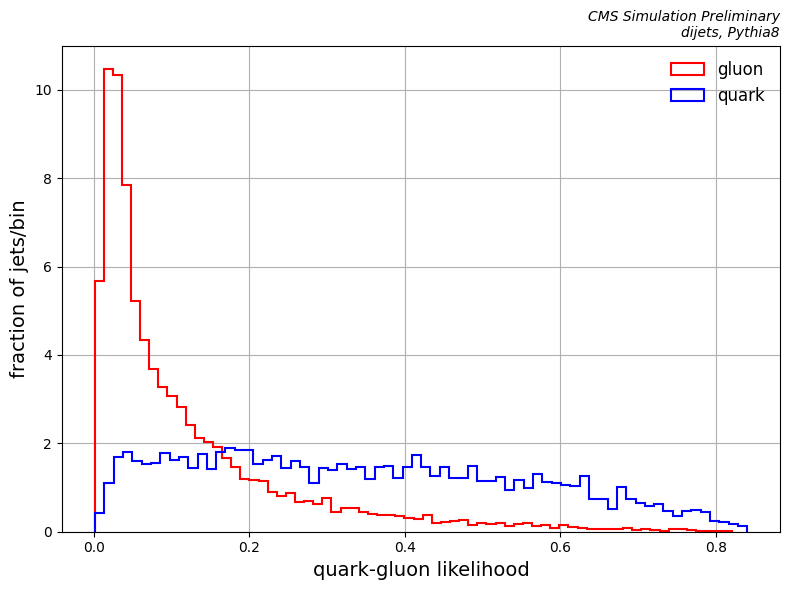

In [93]:
plt.figure(figsize=(8, 6))
plt.hist(ypred[y_test == 0], bins=70, density=True, histtype='step', linewidth=1.5, color='red', label='gluon')
plt.hist(ypred[y_test == 1], bins=70, density=True, histtype='step', linewidth=1.5, color='blue', label='quark')

# Labels and title
plt.xlabel('quark-gluon likelihood', fontsize=14)
plt.ylabel('fraction of jets/bin', fontsize=14)
plt.title('CMS Simulation Preliminary\ndijets, Pythia8', loc='right', fontsize=10, style='italic')
plt.grid()

# Legend
plt.legend(frameon=False, fontsize=12)

plt.tight_layout()
plt.show()

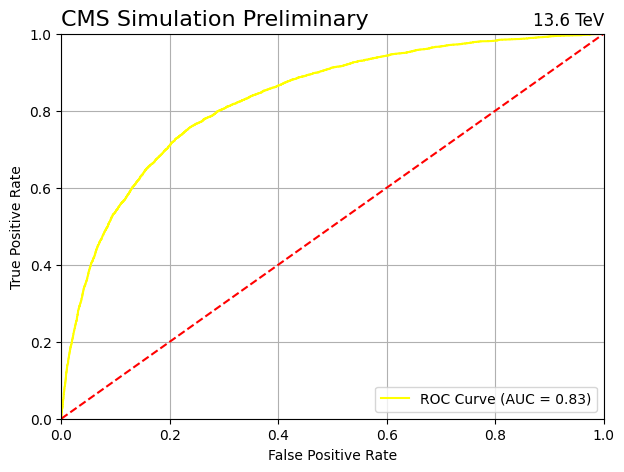

[       inf 0.8407014  0.8219732  ... 0.00153861 0.0015131  0.00094271]


In [94]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, ypred)

# Step 3: Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Step 4: Plot the ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='yellow', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CMS Simulation Preliminary', fontsize=16, loc='left')
plt.text(1, 1.01, "13.6 TeV", ha='right', va='bottom', fontsize=12) 
plt.legend(loc='lower right')
plt.grid()
plt.show()
print(thresholds)

### Boosted Decision Tree Workflow:

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize the BDT model
bdt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=7, random_state=42)

# Fit the model to your training data
bdt.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=7, random_state=42)

In [96]:
y_train_pred = bdt.predict(X_test)
accuracy = accuracy_score(y_test, y_train_pred)

print(f"Training accuracy: {accuracy * 100:.2f}%")

Training accuracy: 82.16%


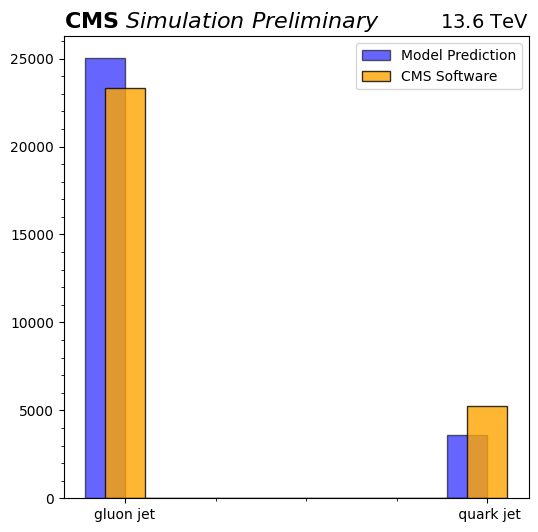

In [97]:
# Create the plot
plt.figure(figsize=(6,6))

# Plot two histograms with transparency
plt.hist(y_train_pred, bins=10,color='blue', alpha=0.6, label='Model Prediction', edgecolor='black')
plt.hist(y_test + 0.05, bins=10,color='orange', alpha=0.8, label='CMS Software', edgecolor='black')




# Add a legend
plt.legend()

# Customize tick marks
# plt.tick_params(axis='both', which='major', length=8, width=1.5, direction='in', top=True, right=True)
# plt.tick_params(axis='both', which='minor', length=4, width=1, direction='in', top=True, right=True)
label = ['gluon jet' , ' quark jet']
plt.xticks(ticks=[0.1,1.0], labels=label)

plt.minorticks_on()
plt.title(r'$\mathbf{CMS}$ $\mathit{Simulation~Preliminary}$', loc='left', fontsize=16)
plt.title(r'$13.6~\mathrm{TeV}$', loc='right', fontsize=14)
plt.savefig("Comparision.")
plt.show()

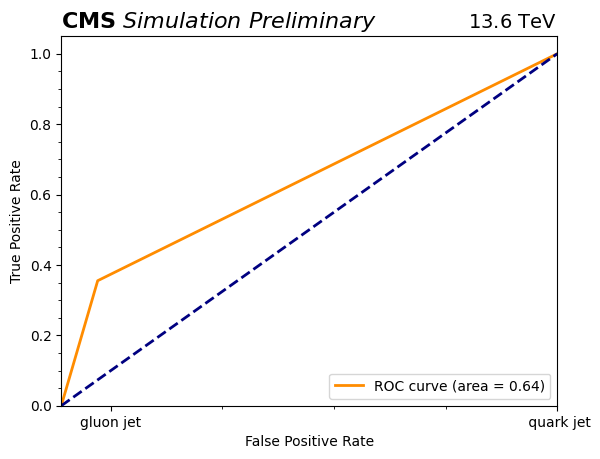

In [98]:
# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_train_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()

# Add a legend

# Customize tick marks
# plt.tick_params(axis='both', which='major', length=8, width=1.5, direction='in', top=True, right=True)
# plt.tick_params(axis='both', which='minor', length=4, width=1, direction='in', top=True, right=True)
label = ['gluon jet' , ' quark jet']
plt.xticks(ticks=[0.1,1.0], labels=label)

plt.minorticks_on()
plt.title(r'$\mathbf{CMS}$ $\mathit{Simulation~Preliminary}$', loc='left', fontsize=16)
plt.title(r'$13.6~\mathrm{TeV}$', loc='right', fontsize=14)
plt.savefig("Comparision.")
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()